In [3]:
%matplotlib inline

In [4]:
import sklearn
from sklearn.decomposition import PCA
import pandas as pd
import json
import numpy as np
from matplotlib import pyplot as plt

# Load the data into two easy to use structures. Pandas and plain vectors

In [5]:
parties = json.load(open('data/antwoorden_stemwijzer_2017.json'))

In [7]:
party_names = []
statements = []
data=[]
for party in parties:
    positions = list(map(lambda x: x['position'], party['statements']))
    party_names.append(party['name'])
    statements.append(positions)
    
    for statement in party['statements']:
        data.append((party['name'], statement['statementID'], statement['position']))

In [8]:
data = pd.DataFrame(data, columns=['party', 'statement', 'position'])

In [9]:
party_names

['VVD',
 'PvdA',
 'PVV',
 'SP',
 'CDA',
 'D66',
 'ChristenUnie',
 'GroenLinks',
 'SGP',
 'Partij voor de Dieren',
 '50Plus',
 'OndernemersPartij',
 'VNL',
 'DENK',
 'Nieuwe Wegen',
 'Forum voor Democratie',
 'De Burger Beweging',
 'Vrijzinnige Partij',
 'Piratenpartij',
 'Artikel 1',
 'Niet Stemmers',
 'Libertarische Partij',
 'Lokaal in de Kamer']

In [10]:
#Data manually copied from peilingwijzer at 18-02-2017
zetels = {'VVD': 24, 'PvdA':12, 'PVV':26, 'SP':13, 'CDA':17, 'D66':17,
          'ChristenUnie':6, 'GroenLinks':16, 'SGP':4, 'Partij voor de Dieren':5,
          '50Plus': 9, 'VNL':0.5, 'DENK':1, 'Forum voor Democratie':0.5}

# PCA plot

In [11]:
pca = PCA(n_components=2)

pca.fit(np.array(statements))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [12]:

coords = pca.transform(statements)

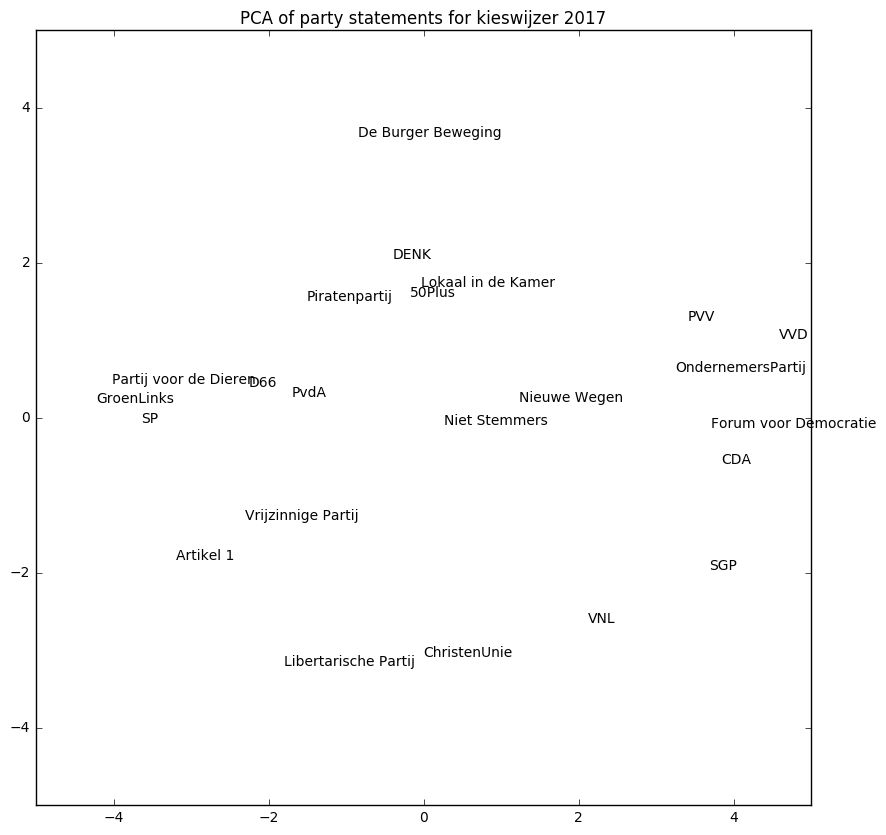

In [13]:
plt.figure(figsize=(10,10))
#plt.plot(coords[:3], 'x', )
for (i,party) in enumerate(party_names):
    plt.annotate(party, coords[i])
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.title('PCA of party statements for kieswijzer 2017')

# Possible Coalitions
Use Axelrod's method. Make a group of parties with the least stress, but a majority in government

In [14]:
from itertools import combinations

In [15]:
def stress (x,y):
    total = 0
    if x not in party_names or y not in party_names:
        raise ValueError('Unknown party')
    x = party_names.index(x)
    y = party_names.index(y)
    s1 = statements[x]
    s2 = statements[y]
    for i in range(len(statements[0])):
        if s1[i] != s2[i]:
            total += 1
    return total

In [16]:
['{},{}: {}'.format(x[0], x[1],stress(x[0], x[1])) for x in combinations(party_names[:3],2)]

['VVD,PvdA: 18', 'VVD,PVV: 11', 'PvdA,PVV: 17']

In [17]:
coals = []
#for n in range(1,len(party_names)):
for n in range(1,8):
    for combi in list(combinations(party_names, n)):
        z = sum([zetels[x] for x in combi if x in zetels.keys()])
        if z > 75:
            s = sum([stress(x[0], x[1]) for x in combinations(combi,2)])
            title = ' '.join(combi)
            coals.append((title, z, s))

In [18]:
coalitions = pd.DataFrame(coals, columns=['coalition', 'zetels', 'stress'])

## Most likely coalitions based upon disagreement in stemwijzer

In [20]:
#Most likely coalitions based upon disagreement in stemwijzer
coalitions.sort_values(by='stress').head(10)

,coalition,zetels,stress
8,VVD PVV CDA 50Plus,76.0,83
0,VVD PvdA PVV CDA,79.0,84
6,VVD PVV CDA D66,84.0,89
1,VVD PvdA PVV D66,79.0,94
3,VVD PVV SP CDA,80.0,97
10,VVD PVV D66 50Plus,76.0,101
2,VVD PvdA PVV GroenLinks,78.0,102
7,VVD PVV CDA GroenLinks,83.0,103
9,VVD PVV D66 GroenLinks,83.0,103
4,VVD PVV SP D66,80.0,105


## Most likely coalitions without PVV
Most parties exclude pvv. So, let's have a look at the most likely coalitions without the PVV

In [23]:
coalitions['has_pvv'] = coalitions.coalition.apply(lambda x: 'PVV' in x)

In [27]:
coalitions[~coalitions.has_pvv].sort_values(by='stress').head(10)

,coalition,zetels,stress,has_pvv
78,VVD PvdA CDA D66 ChristenUnie,76.0,137,False
77,VVD PvdA SP D66 GroenLinks,82.0,138,False
236,VVD SP D66 ChristenUnie GroenLinks,76.0,144,False
82,VVD PvdA D66 GroenLinks 50Plus,78.0,148,False
238,VVD CDA D66 ChristenUnie GroenLinks,80.0,149,False
230,VVD SP CDA D66 ChristenUnie,77.0,149,False
79,VVD PvdA CDA D66 GroenLinks,86.0,151,False
80,VVD PvdA CDA D66 50Plus,79.0,151,False
239,VVD CDA D66 GroenLinks SGP,78.0,152,False
75,VVD PvdA SP CDA D66,83.0,155,False
